# Import

In [1]:
import pandas as pd
import os, torch
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter, MultipleLocator
from exp.plot_config import *

# Setting

In [22]:
from interpret import *
argv = """
  --explainers feature_ablation\
  --root_path ./dataset/electricity/ \
  --data_path electricity.csv \
  --features S \
  --seq_len 96 \
  --label_len 12 \
  --pred_len 24 \
  --n_features 1 \
  --model Crossformer 
""".split()

parser = get_parser()
args = parser.parse_args(argv)
print(args)

setting = stringify_setting(args)

Namespace(task_name='classification', train=False, model='Crossformer', seed=2021, data='mimic', result_path='./results', root_path='./dataset/mimic_iii/', data_path='mimic_iii.pkl', flag='test', features='MS', target='OT', freq='h', checkpoints='./checkpoints/', no_scale=False, group_id=None, seq_len=96, label_len=48, pred_len=96, seasonal_patterns='Monthly', top_k=5, num_kernels=6, n_features=1, d_model=128, n_heads=4, e_layers=2, d_layers=1, d_ff=256, moving_avg=25, factor=3, distil=True, dropout=0.1, embed='timeF', activation='gelu', output_attention=False, conv_kernel=None, num_workers=0, train_epochs=10, batch_size=32, patience=3, learning_rate=0.0001, des=None, loss='MSE', lradj='type1', use_amp=False, use_gpu=True, gpu=0, use_multi_gpu=False, devices='0,1,2,3', p_hidden_dims=[128, 128], p_hidden_layers=2, disable_progress=False, tsr=False, explainers=['feature_ablation'], areas=[0.05, 0.075, 0.1, 0.15], baseline_mode='random', metrics=['mae', 'mse'], threshold=0, avg_attr_by_pr

# Attribution

## Load 

The attribution file at `attr_output_path` will be saved after the interpretation is done for the configuration being passed above. The file size is larger than 50 MB, hence will not be commited in Github.

In [23]:
# (past_features, know_futures)
explainer_name = args.explainers[0]
attr_output_file = f'{args.flag}_{explainer_name}.pt' 
    
output_folder = os.path.join(args.result_path, setting)

figures = os.path.join(output_folder, 'figures')
attr_output_path = os.path.join(output_folder, attr_output_file)

attr = torch.load(attr_output_path)
# attribution of the past features
# attr = attr[0]

In [27]:
is_tuple = type(attr) == tuple
if is_tuple:
    print(attr[0].shape, attr[1].shape)
else:
    print(attr.shape)

In [21]:
# taking the absolute, since we only the magnitude of impact
# attr[0], attr[1] = np.abs(attr[0]), np.abs(attr[1])

## Global importance

In [14]:
if is_tuple:
    past_feature_importance = np.abs(attr[0]).mean(axis=(0, 1, 2))
    time_known_feature_importance = np.abs(attr[1]).mean(axis=(0, 1, 2))
    feature_imp = np.concatenate([past_feature_importance, time_known_feature_importance], axis=0)
else:
    feature_imp = np.abs(attr).mean(axis=(0, 1, 2))

print(feature_imp)
feature_imp_normalized = feature_imp *100 / (feature_imp.sum())
print(feature_imp_normalized)

[0.03048192 0.         0.         0.         0.        ]
[100.   0.   0.   0.   0.]


In [15]:
def normalize(item:np.ndarray, axis=(2,3), l1_norm=False):
    minimum = item.min(axis=axis, keepdims=True)
    maximum = item.max(axis=axis, keepdims=True)
    attr_minmax = (item - minimum)/(maximum-minimum)

    if l1_norm:
        attr_sum = attr_minmax.sum(axis=axis, keepdims=True)
        return attr_minmax / attr_sum 
    else:
        return attr_minmax

## Global Trends

In [16]:
if is_tuple:
    importance = np.mean(np.abs(attr[0]), axis=(0))
    importance = normalize(importance, axis=(1))
else:
    importance = np.mean(np.abs(attr[0]), axis=(0))
    importance = normalize(importance, axis=(1))
    
feature_index = 0

In [18]:
%matplotlib inline

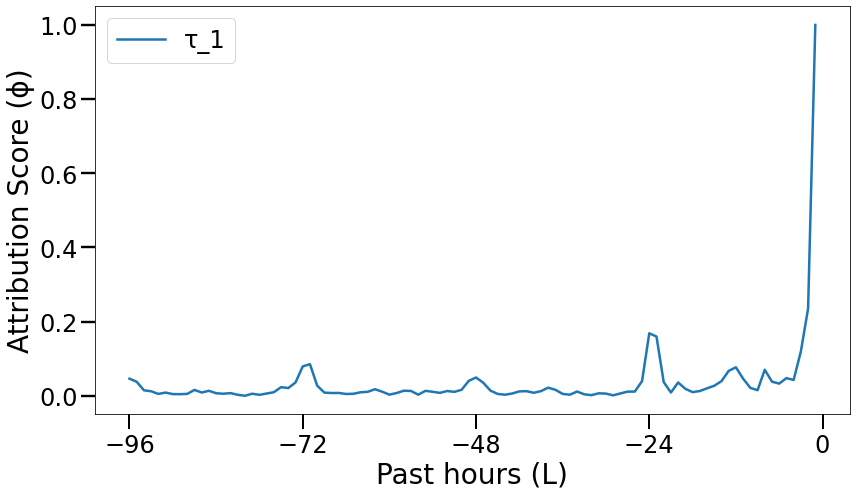

In [20]:
fig, ax = plt.subplots(figsize=(12, 7))
# for i in range(0, importance.shape[0],):
#     ax.plot(range(1, importance.shape[1]+1), importance[i, :, 0], label=f'{i}')
ax.plot(
    range(-importance.shape[1], 0), importance[0, :, feature_index], 
    label=f'τ_1'
)
ax.xaxis.set_major_locator(MultipleLocator(base=24))
ax.set_xlabel('Past hours (L)')
ax.set_ylabel('Attribution Score (ϕ)')
plt.legend()
plt.tight_layout()
# plt.savefig(os.path.join(figures, '1.jpg'), dpi=200)
plt.show()

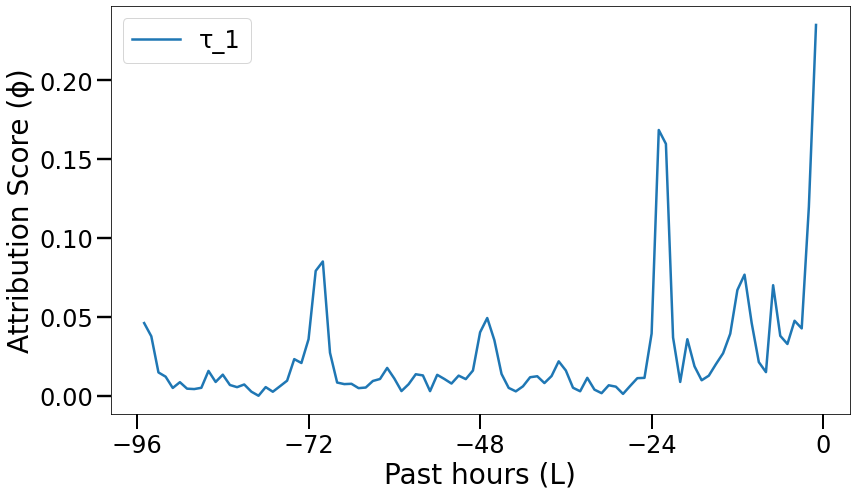

In [21]:
fig, ax = plt.subplots(figsize=(12, 7))
ax.plot(
    # excluding the last past timestep, since it is close to 1
    range(-importance.shape[1]+1, 0), importance[0, :-1, feature_index], 
    label=f'τ_1'
)
ax.xaxis.set_major_locator(MultipleLocator(base=24))
ax.set_xlabel('Past hours (L)')
ax.set_ylabel('Attribution Score (ϕ)')
plt.legend()
plt.tight_layout()
# plt.savefig(os.path.join(figures, '2.jpg'), dpi=200)
plt.show()

In [11]:
fig, ax = plt.subplots(figsize=(12, 7))
for i in range(0, 3, 1):
    ax.plot(
        range(-importance.shape[1]+1, 0), importance[i, :-1, feature_index], 
        label=f'τ_{i+1}', linewidth=2
    )
# ax.plot(range(-importance.shape[1], 0), importance[0, :, 0])
ax.xaxis.set_major_locator(MultipleLocator(base=24))
ax.set_xlabel('Past hours (L)')
ax.set_ylabel('Attribution Score (ϕ)')
plt.legend(ncol=4)
plt.tight_layout()
plt.savefig(os.path.join(figures, '3.jpg'), dpi=200)
plt.show()